In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.abspath(''))
import numpy as np
import pandas as pd
import geopandas as gpd
from geo import COM, PROV, REG, DEMOG
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib notebook

def datech(s):
    return f'{s[6:]}-{s[4:6]}-{s[0:4]}'

def yyymmdd2yyww(yyyymmdd):
    if isinstance(yyyymmdd, str):
        return datetime.strptime(yyyymmdd, '%Y%m%d').strftime('%y-%W')
    elif isinstance(yyyymmdd, (list, tuple)):        
        return [yyymmdd2yyww(_) for _ in yyyymmdd]

In [2]:
CWD = Path(os.path.abspath(''))

data_dir = CWD / 'protezione_civile/COVID-19'
prov_dir = data_dir /  'dati-province'

In [3]:
DEMOG[['prov_name', 'population']].groupby('prov_name').sum().query('prov_name=="roma"')
DEMOG.query('prov_name=="roma" and Sesso=="totale"')
pop = DEMOG.pivot_table(index=['prov_name'], columns=['Sesso', 'Stato civile', 'Età'])['population']['totale']['totale'][['totale']].reset_index()
prov = PROV.merge(pop, on='prov_name')
#prov.plot('totale', legend=True)
#plt.title('Residenti al primo Gennaio 2020')

# Dati della Protezione Civile
Data from [github.com/pcm-dpc/COVID-19](https://github.com/pcm-dpc/COVID-19).

Questi dati sono da aggiornare giornalmente coi comandi:
```
cd covid-19/protezione_civile/COVID-19
git fetch
git merge
```

## Province

In [92]:
df = []
prec = lambda s: f'{s:.4f}'
for f in sorted(prov_dir.glob('dpc-covid19-ita-province-202*.csv')):
    tmp_df = pd.read_csv(f, encoding='latin-1')
    tmp_df['day'] = str(f).split('/')[-1].split('-')[-1].rstrip('.csv')
    tmp_df['geometry'] = gpd.points_from_xy(tmp_df['long'], tmp_df['lat'])
    tmp_df['lat_long'] = tmp_df['lat'].apply(prec).astype(str) + '_' + tmp_df['long'].apply(prec).astype(str)
    df.append(tmp_df)
    del tmp_df
DF = pd.concat(df)
DF.loc[DF['denominazione_provincia'] == 'Napoli', 'sigla_provincia'] = 'NA'
DF['week'] = DF['day'].apply(yyymmdd2yyww)

In [93]:
df = DF.pivot_table(index='sigla_provincia', columns='day', values='totale_casi')
dfw = DF.pivot_table(index='sigla_provincia', columns='week', values='totale_casi', aggfunc='last')
assert all(df.index == dfw.index)

dates = [_ for _ in df.columns if '20' in _]
df = df.diff(periods=1, axis=1)  # total cases -> new cases each day
window = 7
df = df.rolling(window=window, axis=1).mean()  # Moving Window
# weeks = [_ for _ in dfw.columns if '-' in _]
# weeks.pop(0)
# weeks.pop(-1)
# l = list(zip(df.columns, yyymmdd2yyww(df.columns.tolist())))
# new_cols = pd.MultiIndex.from_tuples(l, names=['day', 'week'])
# df.columns = new_cols

df['totale_casi'] = df.sum(1)
df['nuovi_casi'] = df[dates[-1]]

In [94]:
m = prov.merge(df, left_on='prov_acr', right_on='sigla_provincia')
tocsv = pd.DataFrame(m.drop(columns=['geometry', 'prov_istat_code_num', 'reg_istat_code', 'reg_istat_code_num', 'prov_istat_code']))
m['casi_100k'] = m['totale_casi'] / m['totale'] * 100000
m['nuovi_casi_100k'] = m['nuovi_casi'] / m['totale'] * 100000
m['var_perc_1day'] = 100 * (m[dates[-1]] - m[dates[-window]]) / m[dates[-window]]

In [7]:
# tocsv.rename(mapper={'totale': 'residenti'}, axis=1).to_csv('csv/andamento_province.csv', index=False)

Window: 7


<IPython.core.display.Javascript object>


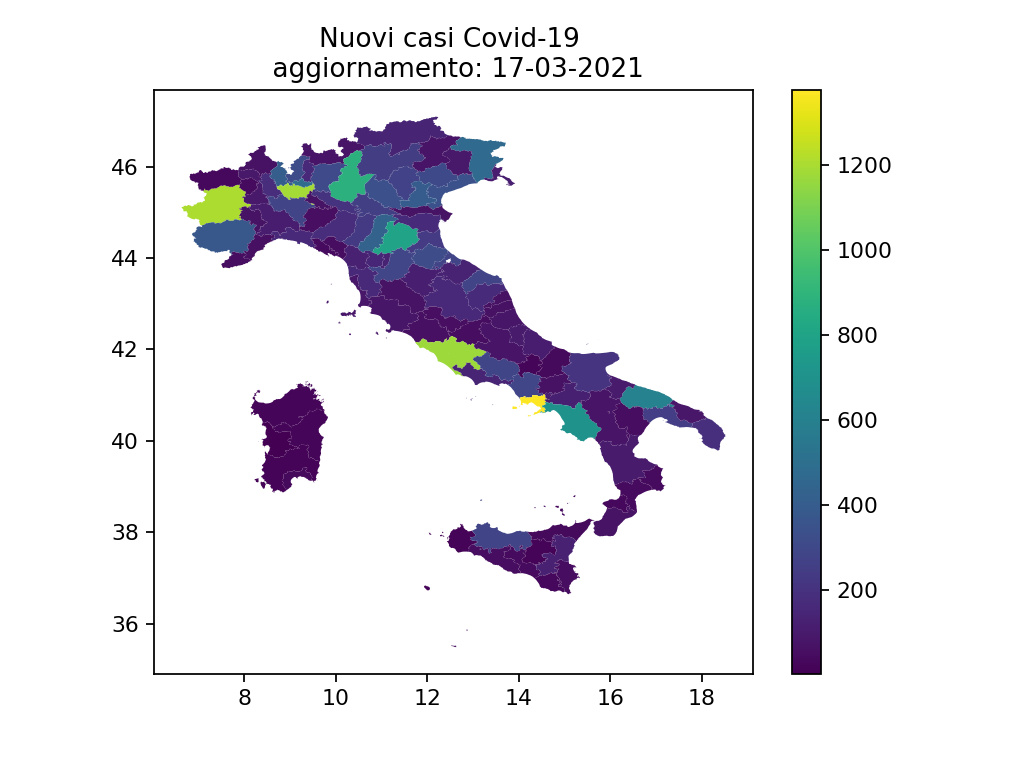

<IPython.core.display.Javascript object>


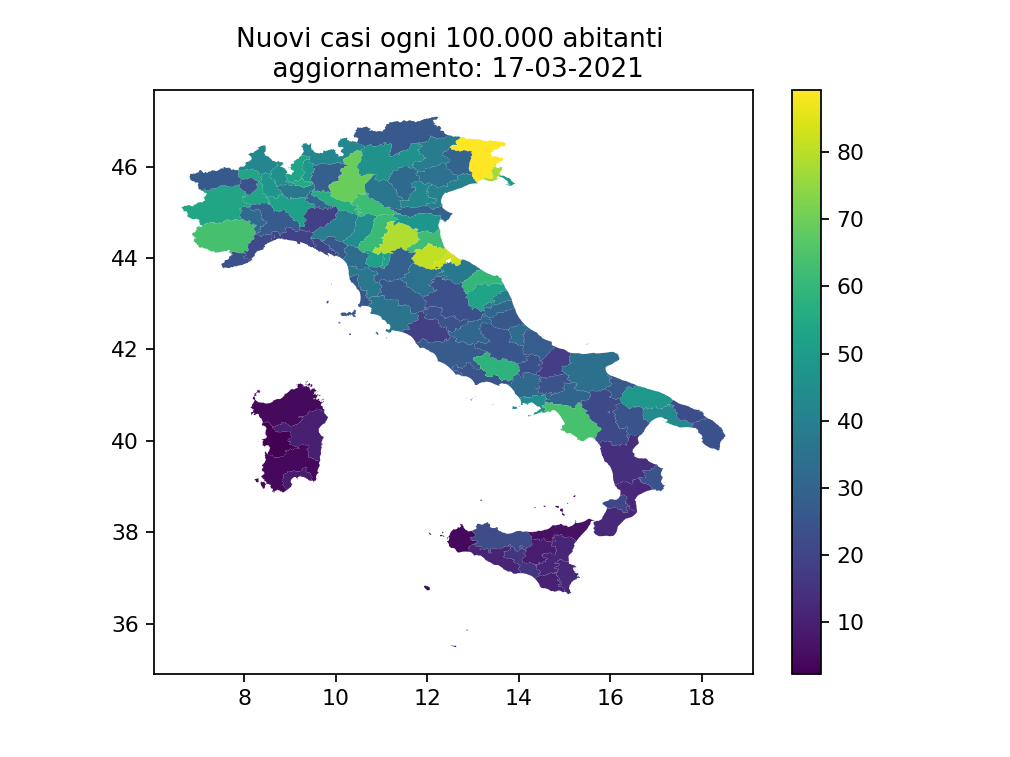

<IPython.core.display.Javascript object>


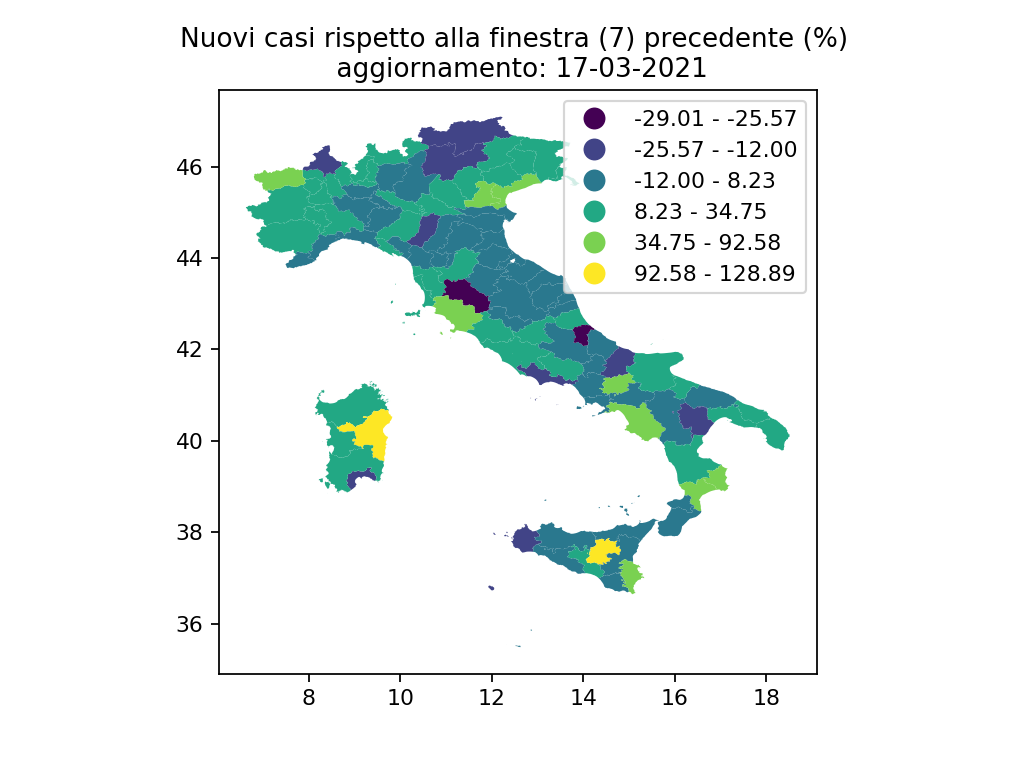

Text(0.5, 1.0, 'Nuovi casi rispetto alla finestra (7) precedente (%) \n aggiornamento: 17-03-2021')

In [103]:
print(f'Window: {window}')
date_ddmmyyyy = datech(dates[-1])
m.plot(column='nuovi_casi', legend=True)
plt.title(f'Nuovi casi Covid-19 \n aggiornamento: {date_ddmmyyyy}')

m.plot(column='nuovi_casi_100k', legend=True)
plt.title(f'Nuovi casi ogni 100.000 abitanti \n aggiornamento: {date_ddmmyyyy}')

#m.plot(column='var_perc_1day', legend=True, scheme='user_defined', classification_kwds={'bins':[25, 50, 75, 100]})
m.plot(column='var_perc_1day', legend=True, scheme='percentiles')
plt.title(f'Nuovi casi rispetto alla finestra ({window}) precedente (%) \n aggiornamento: {date_ddmmyyyy}')

#m.plot(column='casi_100k', legend=True)
#plt.title(f'Casi totali ogni 100.000 abitanti \n aggiornamento: {df.columns[-3]}')

# Andamento per Regioni

In [9]:
df = DF.pivot_table(index='denominazione_regione', columns='data', values='totale_casi', aggfunc=np.sum)
df['incremento'] = df[df.columns[-1]] - df[df.columns[-2]]
df = df.sort_values(['incremento', df.columns[-1]], ascending=[0, 0])
display(df[df.columns[-3:]])

data,2021-03-16T17:00:00,2021-03-17T17:00:00,incremento
denominazione_regione,,,
Lombardia,673458,677948,4490
Campania,308101,310766,2665
Piemonte,277295,279669,2374
Veneto,357056,359247,2191
Emilia-Romagna,304314,306324,2010
Puglia,167399,169133,1734
Lazio,258829,260557,1728
Toscana,175335,176610,1275
Friuli Venezia Giulia,87217,88203,986


# Andamento per Province

In [10]:
df = DF.pivot_table(index=['sigla_provincia', 'denominazione_provincia'], columns='data', values='totale_casi', aggfunc=np.sum)
df['incremento'] = (df.iloc[:, -1] - df.iloc[:, -2])
df = df.sort_values(['incremento', df.columns[-2]], ascending=[0, 0]).reset_index()
df.index.rename('rank', inplace=True)
df.columns.rename('', inplace=True)
BRi = df.query('sigla_provincia=="BR"').index.values[0]
BSi = df.query('sigla_provincia=="BS"').index.values[0]
display(df.iloc[[0,1,2,3,4,5,6,7,8,9,10,11,12,BSi,BRi,-3,-2,-1], [1,-2,-1]])

,denominazione_provincia,2021-03-17T17:00:00,incremento
rank,,,
0,Torino,149462,1272
1,Milano,225108,1050
2,Brescia,83384,949
3,Frosinone,24974,759
4,Latina,25559,613
5,Bari,65967,570
6,Udine,42221,532
7,Salerno,49729,493
8,Treviso,69430,491


<IPython.core.display.Javascript object>


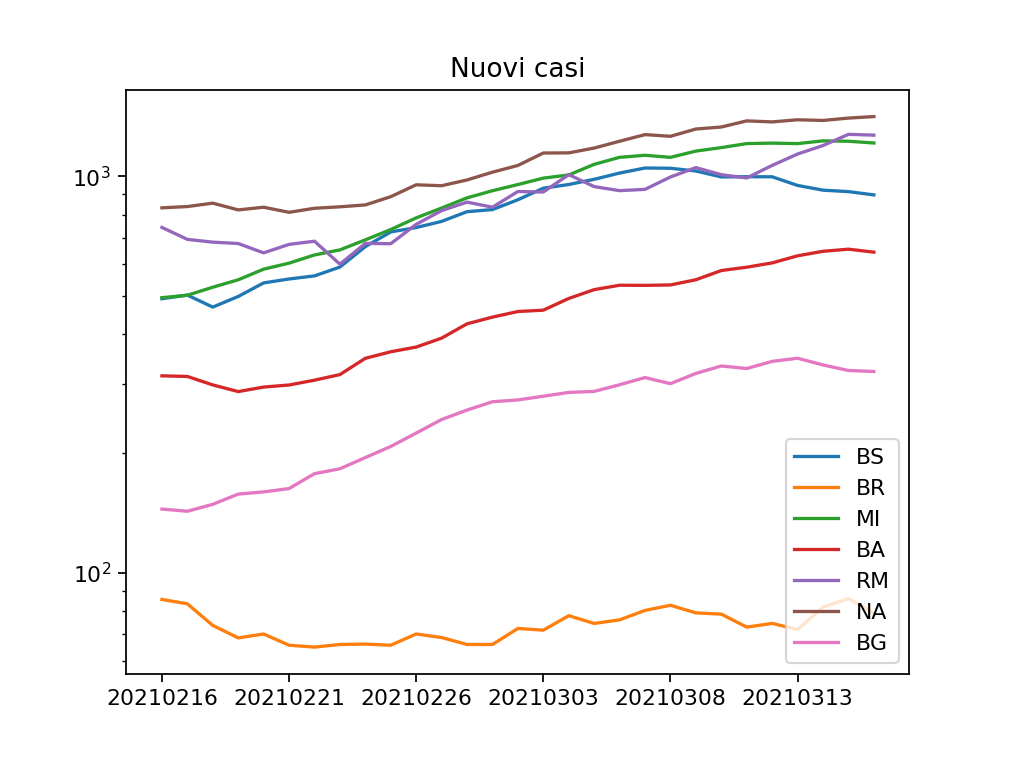

In [118]:
provs = ('BS', 'BR', 'MI', 'BA', 'RM', 'NA', 'BG')
plt.figure()
plt.title('Nuovi casi')
for p in provs:
    m[['prov_acr']+dates[-30:-1:1]].set_index('prov_acr').T[p].plot(logy=True)
plt.legend(provs)


# Regioni

In [12]:
reg_dir = data_dir /  'dati-regioni'
df = []
prec = lambda s: f'{s:.4f}'
for f in sorted(reg_dir.glob('dpc-covid19-ita-regioni-202*.csv')):
    tmp_df = pd.read_csv(f, encoding='latin-1')
    df.append(tmp_df)
    del tmp_df
DF = pd.concat(df)

In [13]:
morti = DF.pivot_table(index='denominazione_regione', columns='data', values='deceduti').sum().to_numpy()
np.diff(morti)

array([  3,   2,   5,   4,   8,   5,  18,  27,  28,  41,  49,  36, 133,
        97, 168, 196, 189, 250, 175, 368, 349, 345, 475, 427, 627, 793,
       651, 601, 743, 683, 662, 969, 889, 756, 812, 837, 727, 760, 766,
       681, 525, 636, 604, 542, 610, 570, 619, 431, 566, 602, 578, 525,
       575, 482, 433, 454, 534, 437, 464, 420, 415, 260, 333, 382, 323,
       285, 269, 474, 174, 195, 236, 369, 274, 243, 194, 165, 179, 172,
       195, 262, 242, 153, 145,  99, 162, 161, 156, 130, 119,  50,  92,
        78, 117,  70,  87, 111,  75,  60,  55,  71,  88,  85,  72,  53,
        65,  79,  71,  53,  56,  78,  44,  26,  34,  43,  66,  47,  49,
        24,  23,  18, -31,  34,  30,   8,  22,   6,  23,  21,  30,  15,
        21,   7,   8,  30,  15,  12,  12,   7,   9,  13,  17,  13,  20,
        11,  14,   3,  13,  15,   9,  10,   5,   5,   5,   5,  11,   6,
         3,   9,   5,   8,  12,   5,  10,   6,   3,  13,   2,   4,   6,
        10,   6,   3, 158,   4,   4,   5,   7,   6,   9,   3,   

In [14]:
casi = DF.pivot_table(index='denominazione_regione', columns='data', values='totale_casi').sum()
np.diff(casi)

array([   93,    78,   250,   238,   240,   566,   342,   466,   587,
         769,   778,  1247,  1492,  1797,   977,  2313,  2651,  2547,
        3497,  3590,  3233,  3526,  4207,  5322,  5986,  6557,  5560,
        4789,  5249,  5210,  6153,  5959,  5974,  5217,  4050,  4053,
        4782,  4668,  4585,  4805,  4316,  3599,  3039,  3836,  4204,
        3951,  4694,  4092,  3153,  2972,  2667,  3786,  3493,  3491,
        3047,  2256,  2729,  3370,  2646,  3021,  2357,  2324,  1739,
        2091,  2086,  1872,  1965,  1900,  1389,  1221,  1075,  1444,
        1401,  1327,  1083,   802,   744,  1402,   888,   992,   789,
         875,   675,   451,   813,   665,   642,   652,   669,   531,
         300,   397,   584,   593,   516,   416,   355,   178,   318,
         321,   177,   518,   270,   197,   280,   283,   202,   379,
         163,   346,   338,   301,   210,   328,   331,  -148,   264,
         224,   221,   113,   577,   296,   255,   175,   174,   126,
         142,   182,

<IPython.core.display.Javascript object>


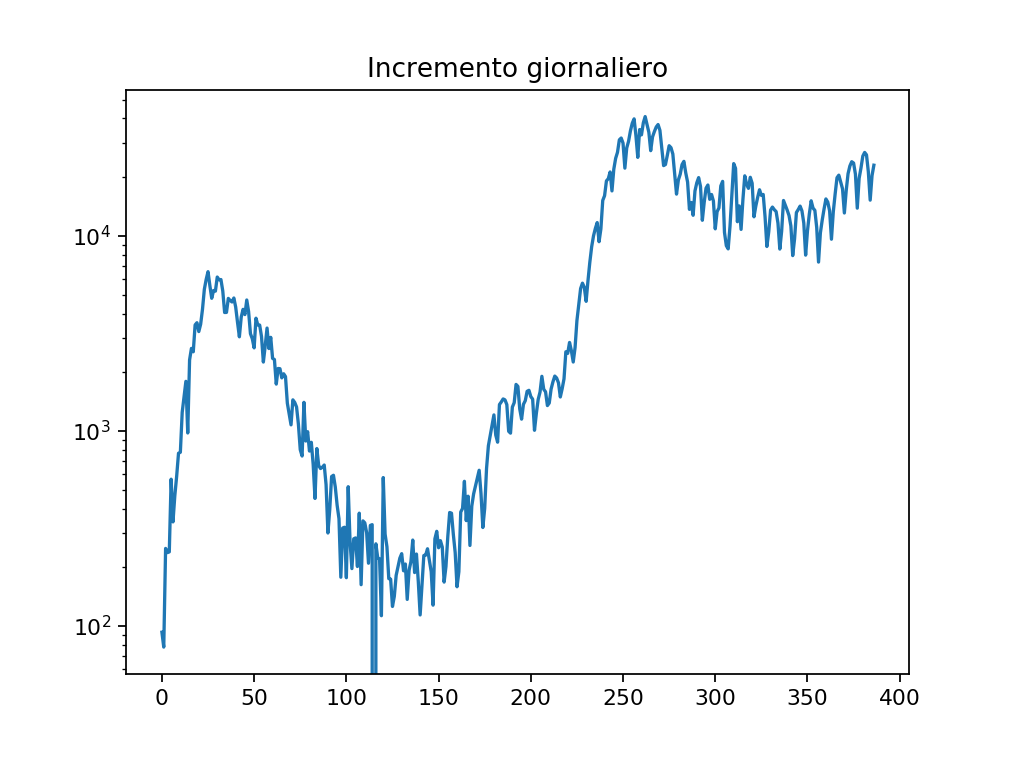

<IPython.core.display.Javascript object>


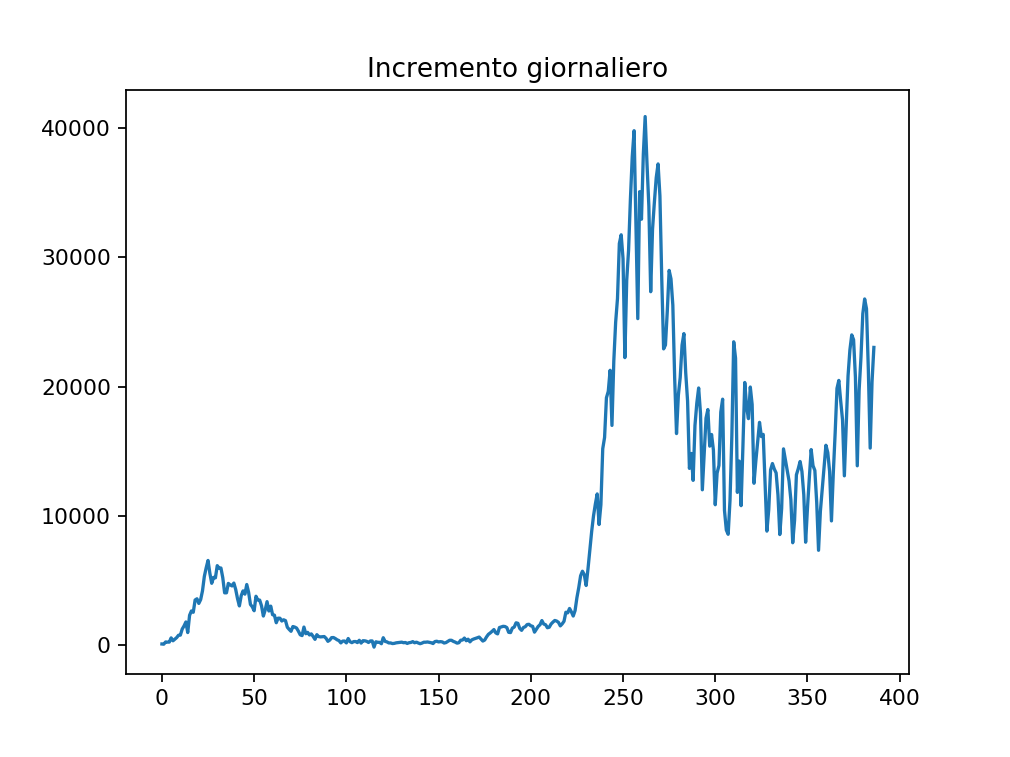

Text(0.5, 1.0, 'Incremento giornaliero')

In [15]:
plt.figure()
plt.semilogy(np.diff(casi))
plt.title('Incremento giornaliero')

plt.figure()
plt.plot(np.diff(casi))
plt.title('Incremento giornaliero')

# Dati Johns Hopkins
Data from [github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [17]:
df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '3/7/21', '3/8/21', '3/9/21', '3/10/21', '3/11/21', '3/12/21',
       '3/13/21', '3/14/21', '3/15/21', '3/16/21'],
      dtype='object', length=424)

<IPython.core.display.Javascript object>


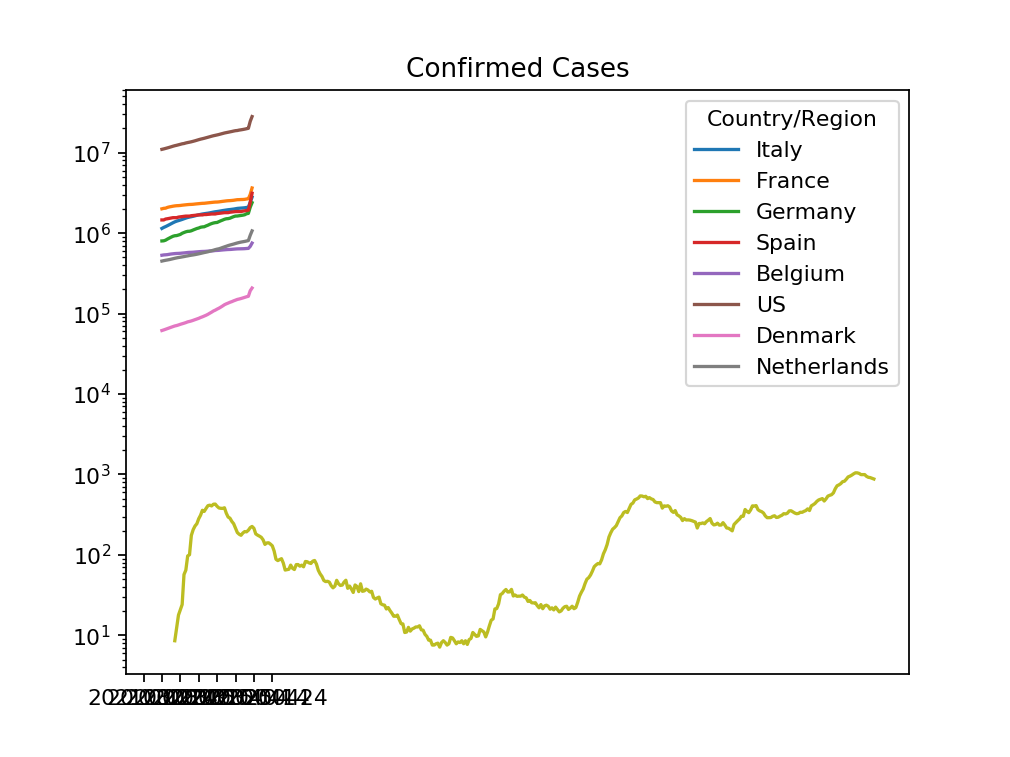

In [18]:
countries = ['Italy','France','Germany','Spain','Belgium', 'US', 'Denmark', 'Netherlands']
jhdates = [c for c in df.columns if '/20' in c]
df.groupby('Country/Region').sum().loc[countries][jhdates[-50:]].T.plot(logy=True, title='Confirmed Cases')

# Andamento Globale

In [19]:
df = df.groupby('Country/Region').sum().loc[countries][jhdates[-10:]]
df['increment'] = df.iloc[:, -1] - df.iloc[:, -2]
df = df.sort_values(['increment', df.columns[-1]], ascending=[0, 0])
display(df)

,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/20/21,2/20/21,increment
Country/Region,,,,,,,,,,,
US,18775207,18872822,19099125,19254759,19429410,19629601,19863235,20098800,24516852,28116088,3599236
Spain,1854951,1854951,1854951,1854951,1879413,1893502,1910218,1928265,2412318,3133122,720804
France,2584333,2604595,2607688,2616510,2619616,2631110,2657624,2677666,3023661,3642654,618993
Italy,2009317,2028354,2038759,2047696,2056277,2067487,2083689,2107166,2414166,2795796,381630
Germany,1630596,1632736,1646240,1658639,1672643,1692109,1741153,1760520,2100618,2388421,287803
Netherlands,743493,755038,764907,774009,781467,789059,798592,808382,940106,1066522,126416
Belgium,634904,637246,638030,638877,639734,641411,644242,646496,684256,752379,68123
Denmark,146927,149926,151764,153952,156434,159074,161862,164116,192187,207769,15582


# France

In [20]:
FR = pd.read_csv('https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv')

/user/lantelmi/home/Software/Python3/miniconda3/envs/torch-1.4/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
idx = ['DEP' in _ for _ in FR['maille_code']]
DEP = FR.loc[idx].pivot_table(index=['maille_code', 'maille_nom'], columns=['date'], values=['cas_confirmes']).droplevel(level=0, axis=1)
DEP.sum(1).sort_values(ascending=False).to_frame().iloc[:25]

,,0
maille_code,maille_nom,
DEP-68,Haut-Rhin,4106.000000
DEP-56,Morbihan,3405.000000
DEP-69,Rhône,3222.000000
DEP-13,Bouches-du-Rhône,3038.000000
DEP-74,Haute-Savoie,2830.333333
DEP-42,Loire,2009.000000
DEP-2A,Corse-du-Sud,1976.000000
DEP-44,Loire-Atlantique,1912.500000
DEP-67,Bas-Rhin,1876.000000


In [22]:
FR.columns.unique(
)

Index(['date', 'granularite', 'maille_code', 'maille_nom', 'cas_confirmes',
       'cas_ehpad', 'cas_confirmes_ehpad', 'cas_possibles_ehpad', 'deces',
       'deces_ehpad', 'reanimation', 'hospitalises',
       'nouvelles_hospitalisations', 'nouvelles_reanimations', 'gueris',
       'depistes', 'source_nom', 'source_url', 'source_archive',
       'source_type'],
      dtype='object')